↓ 读入数据，去除停用词、数字、统一大小写

In [43]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

data = pd.read_csv('./data/all_news.csv')
nRowsRead = None

# remove numbers, punctuations, and lowercasing the words
def rid_of_specials(sentence):
    return re.sub('[^A-Za-z]+', ' ', sentence).lower()
data['body'] = data['body'].astype(str).apply(rid_of_specials)

# remove stopwords
stop_words = set(stopwords.words('english'))
def remove_sw(x):
    x = x.split(' ')
    return ' '.join(z for z in x if z not in stop_words)
stopped = data['body'].apply(remove_sw)

# lemmatizing
lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(i) for i in stopped]
prepeared_sentence = [''.join(j) for j in lemmatized]
data['body'] = prepeared_sentence
# print(data.iloc[0]['body'])


↓ 将所有单词整理成字典保存

In [44]:

datalen = len(data)
# print(datalen)
invertedidx = dict() # 单词的倒排索引，key是单词，value是一个list，表示哪些文章里出现了此单词

for i, sentence in enumerate(prepeared_sentence):
    wordlst = sentence.split(' ')
    for word in wordlst:
        if word not in invertedidx:
            invertedidx[word] = set()
        else:
            if i not in invertedidx[word]:
                invertedidx[word].add(i)

file = open('./data/vocab.txt', 'w')
file.write('\n'.join(invertedidx.keys()))
file.close()

以下的几个代码块都是在生成词的TF-IDF向量

In [45]:
import numba

split_words = data['body'].str.split(' ', expand=True).stack().rename('word').reset_index()
new_data = pd.merge(data['title'], split_words, left_index=True, right_on='level_0')
new_data

poems = new_data.groupby('title')

@numba.jit
def occtime(x):
    poem = poems.get_group(x['title'])
    # print(poem['word'], x['word'])
    return poem['word'].value_counts()[x['word']]
    
wordsperpoem = new_data.groupby('title').apply(lambda x: len(x))



下面这个框框要跑一会……（几分钟）

In [ ]:
tf = new_data.apply(lambda x: occtime(x)/wordsperpoem[x['title']], axis=1)
new_data['TF'] = tf

In [50]:
import math
Fcount = len(new_data.groupby('title'))
refcount = new_data.groupby('word').apply(lambda x: x['title'].count())
IDF = refcount.apply(lambda x: math.log(Fcount/x))
IDF = pd.DataFrame(IDF, columns=['IDF'])
IDF = IDF.reset_index()
new_data = pd.merge(new_data, IDF).sort_values(by=['title', 'level_0', 'level_1'])
new_data['TF-IDF'] = new_data.apply(lambda x: x['TF']*x['IDF'], axis=1)

print(new_data)

                                   title  level_0  level_1        word  \
0       $1m payoff for former Shell boss      418        0       shell   
27      $1m payoff for former Shell boss      418        1         pay   
311     $1m payoff for former Shell boss      418        2          ex   
397     $1m payoff for former Shell boss      418        3     finance   
512     $1m payoff for former Shell boss      418        4       chief   
...                                  ...      ...      ...         ...   
369018  iTunes now selling Band Aid song      669       97      virgin   
439945  iTunes now selling Band Aid song      669       98  woolworths   
449208  iTunes now selling Band Aid song      669       99    donating   
331062  iTunes now selling Band Aid song      669      100     profits   
27732   iTunes now selling Band Aid song      669      101               

              TF       IDF    TF-IDF  
0       0.046154  4.351949  0.200859  
27      0.015385  1.998812  0.030

由词的tfidf生成文章向量和词向量

In [51]:
import numpy as np
f = open('./data/vocab.txt')
word_list = f.read().split('\n')

def buildvec(x):
    vec = np.zeros(len(word_list))
    for i, row in x.iterrows():
        try:
            idx = word_list.index(row['word'])
        except:
            continue
        vec[idx] = row['TF-IDF']
    return vec

poemvec = new_data.groupby('level_0').apply(lambda x: buildvec(x))

In [55]:
from sklearn.preprocessing import normalize
shape = (len(poemvec), len(poemvec[0]))
X = np.ndarray(shape=shape)

for i in range(shape[0]):
    for j in range(shape[1]):
        X[i][j] = poemvec[i][j]

np.save('./data/tfidf_matrix.npy', X) # 储存tfidf矩阵

In [56]:
# 加载文章的分类保存在Y_labels里，待会聚类分析purity要用到
df = pd.read_csv('./data/all_news.csv')
id = {'business':0, 'entertainment':1, 'politics':2, 'sport':3, 'tech':4}
Y_labels = list(id[x] for x in df['topic'])

对tfidf数据进行PCA降维

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

X = np.load('./data/tfidf_matrix.npy')
X = normalize(X)
dims = 1000
pca = PCA(n_components=dims)
Y = pca.fit_transform(X)
Y = normalize(Y)

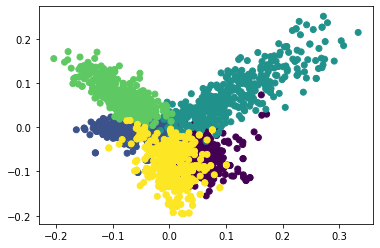

In [58]:
# 数据降维到两维，观察一下数据分布
from matplotlib import pyplot as plt

pca2d = PCA(n_components=2)
X_2d = pca2d.fit_transform(X) # 数据降维至两维便于可视化
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=Y_labels)

In [59]:
np.save('./data/pca.npy', Y)

对降维之后的数据进行聚类，直接调包Kmeans

In [60]:
from sklearn.cluster import KMeans
from sklearn import datasets, preprocessing

Y = np.load('./data/pca.npy')
# print(Y.shape)
Y_std = normalize(Y)
Y_pred = KMeans(n_clusters=5).fit_predict(Y_std)
# print(Y_pred)

nr = pd.DataFrame(np.unique(Y_pred, return_counts=True)).T[1]
print('nr:', nr)
tmp = pd.DataFrame(Y_labels, index=Y_pred)
tmp = tmp.groupby(tmp.index)

maxi = tmp.apply(lambda x: np.unique(x, return_counts=True)[1].max())
psr = maxi
Purity = maxi.sum()/2225
print("Purity=", Purity)

nr: 0    505
1    511
2    455
3    369
4    385
Name: 1, dtype: int64
Purity= 0.9402247191011236


从上面的purity可以看到，文章聚类的效果是不错的，也说明文章向量有意义。

### 根据词向量的cos-similarity来计算模糊词，取六个（包括自己在内）


In [63]:
wordvec = np.load('./data/tfidf_matrix.npy')
wordvec = wordvec.T # 转置之后，每行是一个词向量

f = open('./data/vocab.txt')
word_list = f.read().split('\n')

similar_words = {}

for i in range(wordvec.shape[0]):
    sim = np.dot(wordvec, wordvec[i]).reshape(-1)
    max6 = np.argpartition(sim,-6)
    similar_words[word_list[i]] = list(word_list[x] for x in max6[-6:])


In [64]:
# 输出几个，看看直觉上相关程度如何

print(similar_words['rising'])
print(similar_words['grew'])
print(similar_words['secure'])


['barrel', 'oil', 'rising', 'economy', 'prices', 'crude']
['latin', 'china', 'exports', 'growth', 'grew', 'economy']
['bagle', 'cabir', 'program', 'security', 'secure', 'virus']


In [65]:
f = open('./data/synonym.txt', 'w')
f.write(str(similar_words))
f.close()

通过可视化选择hints算法合适的阈值

(2225, 27614)


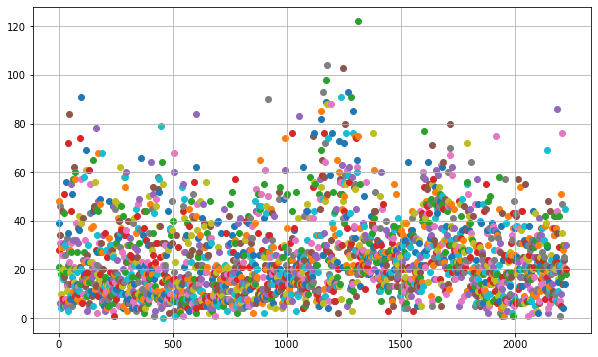

In [66]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np
from matplotlib import pyplot as plt

tfidf = np.load('./data/tfidf_matrix.npy')
tfidf = normalize(tfidf)

print(tfidf.shape)
pca = PCA(n_components=1000).fit_transform(tfidf)
pca = normalize(pca)

def sim_news(x):
    news_similarity = pca @ pca[x]
    return list(np.argwhere(news_similarity > 0.1).reshape((-1)))

plt.figure(figsize=(10,6))
for i in range(tfidf.shape[0]):
    plt.scatter(i, len(sim_news(i))-1)
plt.grid()
plt.show()

选取cos-similarity > 0.1 的文章为相似文章，可以将每篇文章的相似类数量控制在比较合适的范畴内。

这样大部分文章有0~30篇左右的相似文章，据此可以构建网络运行HINTS算法。

In [67]:
# 文章的关键词提取
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

f = open('./data/vocab.txt')
word_list = f.read().split('\n')
tfidf = np.load('./data/tfidf_matrix.npy')
tfidf = normalize(tfidf)
news = pd.read_csv('./data/all_news.csv')

keywords = tfidf.argsort(axis=1)[:, -10:]

print(keywords)
print(news.iloc[1]['title'])
tmp = [word_list[x] for x in keywords[1]]
print(tmp)
print(news.iloc[233]['title'])
tmp = [word_list[x] for x in keywords[233]]
print(tmp)
print(news.iloc[666]['title'])
tmp = [word_list[x] for x in keywords[666]]
print(tmp)
print(news.iloc[114]['title'])
tmp = [word_list[x] for x in keywords[114]]
print(tmp)

np.save('./data/keywords.npy', keywords)

[[   81    22    49 ...    35    39     5]
 [  205   244   225 ...   171   178   181]
 [  356   379   361 ...   337   331   329]
 ...
 [13354 25458 23490 ...  4317 10372  6494]
 [24305   504  4253 ...    89 24472 27538]
 [ 2522 27544 26677 ...  1311  1744 27549]]
Dollar gains on Greenspan speech
['recent', 'falls', 'account', 'federal', 'chinese', 'greenspan', 'currency', 'dollar', 'reserve', 'deficit']
Vodafone appoints new Japan boss
['kk', 'technologically', 'customers', 'shiro', 'tetsuro', 'tsusaka', 'japan', 'tsuda', 'morrow', 'vodafone']
US charity anthem is re-released
['grammys', 'richie', 'sang', 'famine', 'springsteen', 'anthem', 'lionel', 'issued', 'dylan', 'recording']
Glaxo aims high after profit fall
['disappointing', 'discontinued', 'wellbutrin', 'paxil', 'depressants', 'allergies', 'profits', 'pipeline', 'obesity', 'garnier']
